# clustering

The procedure of supernode clustering with respect to different feature sets.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/infrastructure_features.json`
3. `data/features/lspace_features.json`
4. `data/features/pspace_features.json`

Produces:
1. `data/clustering/clusters.json`

In [1]:
import sys
sys.path.append('..')

In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from myutils.json import save_json

from config import supernodes_fpath, infrastructure_features_fpath, lspace_features_fpath, \
    pspace_features_fpath, supernode_clusters_fpath

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[4609, 29290, 3082, 17005, 16142, 15984, 16466...",0.331043,"[bus, trolley, tram]",60.017943,30.367853
1,"[16964, 4677, 19280, 2545, 49, 26803, 26804, 1...",0.237753,"[bus, tram, trolley, subway]",59.990263,30.254647


In [4]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.36785303, 60.01794322],
       [30.25464677, 59.99026319],
       [30.46852237, 59.91982784],
       ...,
       [30.39563275, 59.856488  ],
       [30.3612702 , 59.93006823],
       [30.3595223 , 59.9445053 ]])

In [5]:
infrastructure_features = pd.read_json(infrastructure_features_fpath).set_index('id')

infrastructure_features['total'] /= infrastructure_features['total'].max()

infrastructure_features.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,company,sport,car_supply,organisation,supermarket,hotel_business,electronics_and_telecommunication,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace,total
id,,,,,,,,,,,,,,,,,,,,
0,0.493671,0.113924,0.037975,0.025316,0.050633,0.050633,0.075949,0.025316,0.037975,0.000000,0.025316,0.037975,0.0,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000,0.099246
1,0.014663,0.504399,0.140762,0.102639,0.029326,0.008798,0.008798,0.032258,0.005865,0.017595,0.005865,0.005865,0.0,0.026393,0.008798,0.038123,0.008798,0.020528,0.020528,0.428392


In [6]:
lspace_features = pd.read_json(lspace_features_fpath).set_index('id')

lspace_features.head(2)

,betw_centr,betw_centr_1hop_mean,betw_centr_2hop_mean,cl_centr,cl_centr_1hop_mean,cl_centr_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,degree,degree_1hop_mean,degree_2hop_mean
id,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,58,28.545455,29.580000
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,57,26.615385,19.571429


In [7]:
pspace_features = pd.read_json(pspace_features_fpath).set_index('id')

pspace_features.head(2)

,betw_centr,betw_centr_1hop_mean,betw_centr_2hop_mean,cl_centr,cl_centr_1hop_mean,cl_centr_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,degree,degree_1hop_mean,degree_2hop_mean
id,,,,,,,,,,,,
0,0.012041,0.005576,0.005421,0.042311,0.041452,0.039940,0.308901,0.507988,0.629610,192,126.302083,94.013877
1,0.037970,0.006955,0.005211,0.044394,0.037900,0.040545,0.252879,0.583284,0.611572,230,109.925764,97.260572


In [8]:
graph_features = pd.concat(
    [
        lspace_features.rename(columns=lambda x: 'lspace_' + x),
        pspace_features.rename(columns=lambda x: 'pspace_' + x),
    ],
    axis=1,
)

graph_features.head(2)

,lspace_betw_centr,lspace_betw_centr_1hop_mean,lspace_betw_centr_2hop_mean,lspace_cl_centr,lspace_cl_centr_1hop_mean,lspace_cl_centr_2hop_mean,lspace_clustering,lspace_clustering_1hop_mean,lspace_clustering_2hop_mean,lspace_degree,...,pspace_betw_centr_2hop_mean,pspace_cl_centr,pspace_cl_centr_1hop_mean,pspace_cl_centr_2hop_mean,pspace_clustering,pspace_clustering_1hop_mean,pspace_clustering_2hop_mean,pspace_degree,pspace_degree_1hop_mean,pspace_degree_2hop_mean
id,,,,,,,,,,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,58,...,0.005421,0.042311,0.041452,0.039940,0.308901,0.507988,0.629610,192,126.302083,94.013877
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,57,...,0.005211,0.044394,0.037900,0.040545,0.252879,0.583284,0.611572,230,109.925764,97.260572


In [9]:
for col in graph_features.columns:
    if 'degree' in col:
        graph_features[col] /= graph_features[col].max()

In [10]:
all_features = pd.concat(
    [
        graph_features,
        infrastructure_features.rename(columns=lambda x: 'infr_' + x),
    ],
    axis=1,
)

all_features.head(2)

,lspace_betw_centr,lspace_betw_centr_1hop_mean,lspace_betw_centr_2hop_mean,lspace_cl_centr,lspace_cl_centr_1hop_mean,lspace_cl_centr_2hop_mean,lspace_clustering,lspace_clustering_1hop_mean,lspace_clustering_2hop_mean,lspace_degree,...,infr_organisation,infr_supermarket,infr_hotel_business,infr_electronics_and_telecommunication,infr_bank_and_money,infr_printing_and_books,infr_religion,infr_post_office,infr_business_center_or_mall_or_marketplace,infr_total
id,,,,,,,,,,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,0.414286,...,0.025316,0.037975,0.0,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000,0.099246
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,0.407143,...,0.005865,0.005865,0.0,0.026393,0.008798,0.038123,0.008798,0.020528,0.020528,0.428392


In [11]:
all_features.isna().any().any()

False

## Clustering

In [12]:
def plot_inertia(array: np.ndarray):
    ks = np.arange(2, 20)
    inertia = []

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters=k).fit(array)
        inertia.append(kmeans.inertia_)

    plt.plot(ks, inertia, lw=2, zorder=5)
    
    plt.xticks(ks, ks)
    plt.grid(ls='dotted')
    plt.title('KMeans inertia')
    
    plt.show()
    plt.close()

In [13]:
def plot_clusters(clusters: np.ndarray, tsne: np.ndarray, coords: np.ndarray):
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(12, 6)
    
    arrays = [tsne, coords]
    titles = ['tSNE', 'coordinates']
    
    for ax, array, title in zip(axes, arrays, titles):
        for i in np.unique(clusters):
            subarray = array[clusters == i]
            ax.scatter(*array[clusters == i].T, color=f'C{i}', s=7, label=f'cluster {i}')
            
        ax.axis('off')
        ax.set_title(title)
            
    axes[-1].legend()

## Infrastructure only

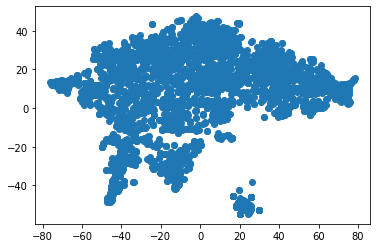

In [14]:
infrastructure_tsne = TSNE().fit_transform(infrastructure_features.values)

plt.scatter(*infrastructure_tsne.T)

100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


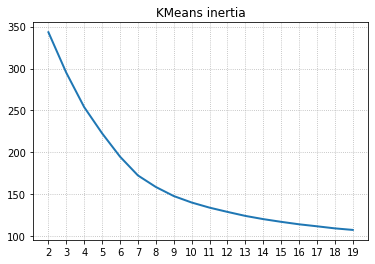

In [15]:
plot_inertia(infrastructure_features.values)

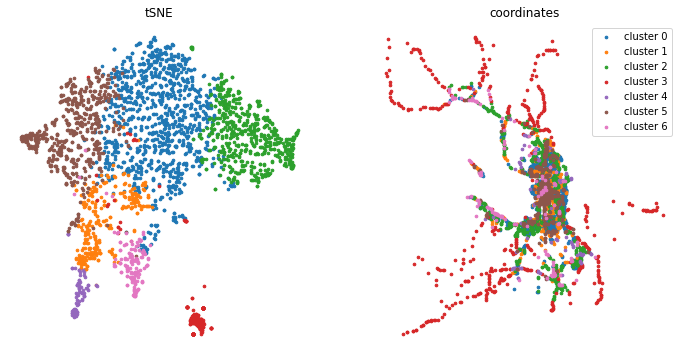

In [16]:
kmeans = KMeans(n_clusters=7).fit(infrastructure_features.values)
infrastructure_clusters = kmeans.predict(infrastructure_features.values)

plot_clusters(infrastructure_clusters, infrastructure_tsne, coords)

## Graph features only

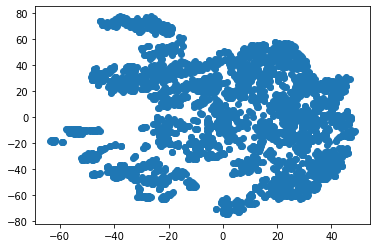

In [17]:
graph_tsne = TSNE().fit_transform(graph_features.values)

plt.scatter(*graph_tsne.T)

100%|██████████| 18/18 [00:18<00:00,  1.05s/it]


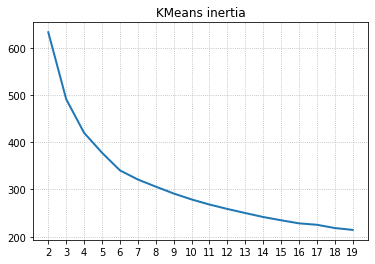

In [18]:
plot_inertia(graph_features.values)

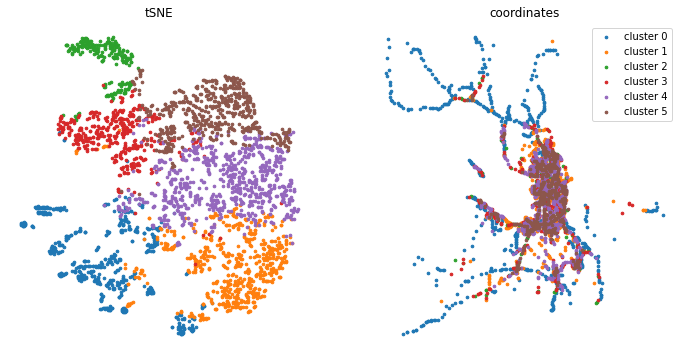

In [19]:
kmeans = KMeans(n_clusters=6).fit(graph_features.values)
graph_clusters = kmeans.predict(graph_features.values)

plot_clusters(graph_clusters, graph_tsne, coords)

## All features

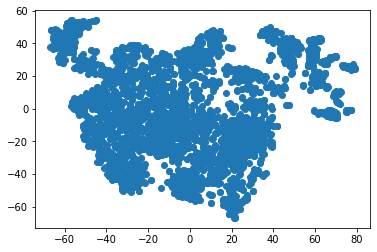

In [20]:
all_tsne = TSNE().fit_transform(all_features.values)

plt.scatter(*all_tsne.T)

100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


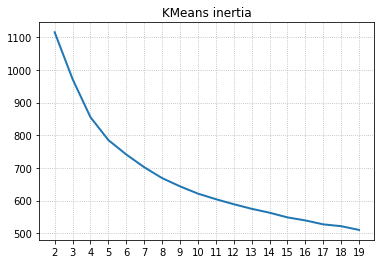

In [21]:
plot_inertia(all_features.values)

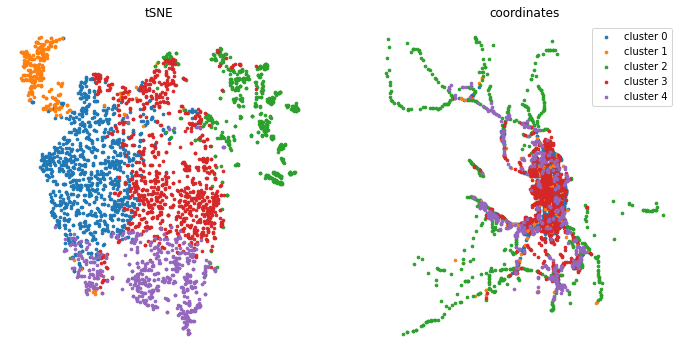

In [22]:
kmeans = KMeans(n_clusters=5).fit(all_features.values)
all_clusters = kmeans.predict(all_features.values)

plot_clusters(all_clusters, all_tsne, coords)

In [24]:
clusters = pd.DataFrame({
    'id': infrastructure_features.index,
    'infrastructure': infrastructure_clusters,
    'graph': graph_clusters,
    'all': all_clusters,
})

clusters.head(2)

,id,infrastructure,graph,all
0,0,0,5,0
1,1,5,5,0


In [25]:
clusters_json = [row.to_dict() for _, row in clusters.iterrows()]

clusters_json[0]

{'id': 0, 'infrastructure': 0, 'graph': 5, 'all': 0}

In [27]:
save_json(clusters_json, supernode_clusters_fpath)